# 📧 Full Spam Email Analysis
This notebook analyzes all emails (ham and spam), extracts metadata (IP, country, org, domain), identifies top spam sources, and categorizes spam emails by type.

In [23]:

import os
import re
import email
import pandas as pd
import requests
from email import policy
from email.parser import BytesParser
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import whois



In [24]:

def parse_email(file_path):
    with open(file_path, 'rb') as f:
        msg = BytesParser(policy=policy.default).parse(f)
    headers = dict(msg.items())
    body = msg.get_body(preferencelist=('plain', 'html'))
    return {
        "subject": headers.get("Subject", ""),
        "from": headers.get("From", ""),
        "to": headers.get("To", ""),
        "received": headers.get("Received", ""),
        "date": headers.get("Date", ""),
        "body": body.get_content() if body else ""
    }

def clean_email_body(raw_html):
    if not raw_html:
        return ""
    soup = BeautifulSoup(raw_html, "html.parser")
    return soup.get_text(separator=" ", strip=True)

def extract_info_from_received(received_header):
    ip_match = re.search(r'\[?(\d{1,3}(?:\.\d{1,3}){3})\]?', received_header)
    ip = ip_match.group(1) if ip_match else None
    domain_match = re.search(r'from\s+([\w\.-]+)', received_header, re.IGNORECASE)
    domain = domain_match.group(1) if domain_match else None
    return ip, domain

def enrich_ip_metadata(ip):
    if not ip or ip.startswith(("192.", "10.", "127.")):
        return {"country": None, "org": None}
    try:
        r = requests.get(f"http://ip-api.com/json/{ip}", timeout=5)
        if r.status_code == 200:
            data = r.json()
            return {"country": data.get("country"), "org": data.get("org")}
    except:
        pass
    return {"country": None, "org": None}

def load_emails_from_folder(folder_path, label):
    emails = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        try:
            parsed = parse_email(file_path)
            ip, domain = extract_info_from_received(parsed["received"])
            emails.append({
                "from": parsed["from"],
                "subject": parsed["subject"],
                "date": parsed["date"],
                "text": clean_email_body(parsed["body"]),
                "ip": ip,
                "domain": domain,
                "label": label
            })
        except Exception as e:
            continue
    return emails

In [25]:
# Load ham and spam emails
ham_emails = load_emails_from_folder("easy_ham", 0)
spam_emails = load_emails_from_folder("spam", 1)
spam2_emails = load_emails_from_folder("spam_2", 1)

# Combine and filter out emails with no body
all_emails = pd.DataFrame(ham_emails + spam_emails + spam2_emails)
all_emails = all_emails[all_emails['text'].notnull()].copy()

# Combine subject and body into one field for spam type analysis
all_emails["subject"] = all_emails["subject"].fillna("")
all_emails["text"] = all_emails["text"].fillna("")
all_emails["combined_text"] = all_emails["subject"] + " " + all_emails["text"]

# Shuffle
all_emails = all_emails.sample(frac=1).reset_index(drop=True)

# Print summary
total_count = len(all_emails)
spam_count = len(all_emails[all_emails['label'] == 1])
ham_count = total_count - spam_count

print(f"📬 Total emails loaded: {total_count}")
print(f"✅ Ham emails: {ham_count}")
print(f"🚫 Spam emails: {spam_count}")


📬 Total emails loaded: 4015
✅ Ham emails: 2501
🚫 Spam emails: 1514


In [26]:
# Get top 30 most frequent IPs from the entire dataset
top_ips = (
    all_emails['ip']
    .dropna()
    .value_counts()
    .head(30)
    .index
)

# Enrich metadata for only those top 30 IPs
ip_metadata = {ip: enrich_ip_metadata(ip) for ip in top_ips}

# Map metadata back into DataFrame (others will be None)
all_emails['country'] = all_emails['ip'].map(lambda ip: ip_metadata.get(ip, {}).get('country') if ip in ip_metadata else None)
all_emails['org'] = all_emails['ip'].map(lambda ip: ip_metadata.get(ip, {}).get('org') if ip in ip_metadata else None)


In [27]:
# Helper: Exclude local/private IPs
def is_valid_ip(ip):
    if not isinstance(ip, str):
        return False
    return not (
        ip.startswith("127.") or
        ip.startswith("10.") or
        ip.startswith("192.168.") or
        ip.startswith("172.")
    )

# Step 1: Filter to valid IPs and get top 30
valid_spam_ips = all_emails[
    (all_emails['label'] == 1) &
    (all_emails['ip'].apply(is_valid_ip))
]['ip'].value_counts().head(30)

top_ips = valid_spam_ips.index.tolist()

# Step 2: Enrich metadata for those IPs
ip_metadata = {ip: enrich_ip_metadata(ip) for ip in top_ips}

# Step 3: Map results
all_emails['country'] = all_emails['ip'].map(lambda ip: ip_metadata.get(ip, {}).get('country') if ip in ip_metadata else None)
all_emails['org'] = all_emails['ip'].map(lambda ip: ip_metadata.get(ip, {}).get('org') if ip in ip_metadata else None)

# Step 4: Now safely calculate Top 5 Spam IPs and Countries
top_ips_display = valid_spam_ips.head(5)
print("Top 5 Spam IPs (Valid Only):")
print(top_ips_display)

top_countries = (
    all_emails[
        (all_emails['label'] == 1) &
        (all_emails['ip'].isin(top_ips)) &
        (all_emails['country'].notna())
    ]['country']
    .value_counts()
    .head(5)
)
print("\nTop 5 Spam Countries:")
print(top_countries)

# Optional: Top valid domains (excluding generic ones)
top_domains = (
    all_emails[
        (all_emails['label'] == 1) &
        (~all_emails['domain'].isin(["unknown", "mail"])) &
        (all_emails['domain'].notna())
    ]['domain']
    .value_counts()
    .head(5)
)
print("\nTop 5 Spam Domains:")
print(top_domains)


top_countries = (
    all_emails[
        (all_emails['label'] == 1) &
        (all_emails['ip'].isin(top_ips))
    ]["country"]
    .dropna()
    .value_counts()
    .head(5)
)

# Count how many spam emails come from local/invalid IPs
invalid_ip_count = all_emails[
    (all_emails['label'] == 1) &
    (~all_emails['ip'].apply(is_valid_ip))
].shape[0]

print(f"\n🚫 Spam emails from invalid/private IPs: {invalid_ip_count}")




Top 5 Spam IPs (Valid Only):
ip
130.94.4.23      5
217.78.76.138    5
216.82.8.17      4
64.14.243.42     4
218.6.8.11       4
Name: count, dtype: int64

Top 5 Spam Countries:
country
United States    47
China            15
Mexico            4
Spain             3
Argentina         3
Name: count, dtype: int64

Top 5 Spam Domains:
domain
mx1.mail.yahoo.com    25
hotmail.com           20
smtp-gw-4.msn.com     19
aol.com               18
yahoo.com             17
Name: count, dtype: int64

🚫 Spam emails from invalid/private IPs: 323


In [28]:
# Using the virustotal to check the IPs

import requests
import time
# Step 4: Now safely calculate Top 5 Spam IPs and Countries
top_ips_display = valid_spam_ips.head(5)
print("Top 5 Spam IPs (Valid Only):")
print(top_ips_display)

# ⛳ Replace this with your actual API key from VirusTotal
VT_API_KEY = "e98baef21d48f79464a4bd3494609ed97d3d22cf71827be1125ba4271d7d12c6"
def check_ip_virustotal(ip):
    url = f"https://www.virustotal.com/api/v3/ip_addresses/{ip}"
    headers = {
        "x-apikey": VT_API_KEY
    }

    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            data = response.json()
            stats = data["data"]["attributes"]["last_analysis_stats"]
            malicious = stats.get("malicious", 0)
            suspicious = stats.get("suspicious", 0)
            harmless = stats.get("harmless", 0)
            undetected = stats.get("undetected", 0)
            total = sum(stats.values())

            print(f"🔍 IP: {ip}")
            print(f"  Malicious: {malicious}, Suspicious: {suspicious}, Harmless: {harmless}, Undetected: {undetected}")
            print(f"  Verdict: {'⚠️ Malicious' if malicious > 0 or suspicious > 0 else '✅ Clean'}")
            print("-" * 50)
        else:
            print(f"❌ Error {response.status_code} for IP: {ip}")
    except Exception as e:
        print(f"❌ Exception for IP {ip}: {e}")

# 🔁 Example: check a few IPs (replace with your list)
ip_list = ip_list = top_ips_display.index.tolist() 

for ip in ip_list:
    check_ip_virustotal(ip)
    time.sleep(16)  # VirusTotal free API limit: 4 requests/min (one every 15 sec)


Top 5 Spam IPs (Valid Only):
ip
130.94.4.23      5
217.78.76.138    5
216.82.8.17      4
64.14.243.42     4
218.6.8.11       4
Name: count, dtype: int64
🔍 IP: 130.94.4.23
  Malicious: 0, Suspicious: 0, Harmless: 0, Undetected: 94
  Verdict: ✅ Clean
--------------------------------------------------
🔍 IP: 217.78.76.138
  Malicious: 0, Suspicious: 0, Harmless: 0, Undetected: 94
  Verdict: ✅ Clean
--------------------------------------------------
🔍 IP: 216.82.8.17
  Malicious: 0, Suspicious: 0, Harmless: 0, Undetected: 94
  Verdict: ✅ Clean
--------------------------------------------------
🔍 IP: 64.14.243.42
  Malicious: 0, Suspicious: 0, Harmless: 0, Undetected: 94
  Verdict: ✅ Clean
--------------------------------------------------
🔍 IP: 218.6.8.11
  Malicious: 0, Suspicious: 0, Harmless: 0, Undetected: 94
  Verdict: ✅ Clean
--------------------------------------------------


In [29]:
# using the whois to check the domains
top_domains_list = top_domains.index.tolist()

print("📬 WHOIS Info for Top 5 Domains:\n")
for domain in top_domains_list:
    try:
        w = whois.whois(domain)
        print(f"Domain: {domain}")
        print(f"  Registrar: {w.registrar}")
        print(f"  Org: {w.org}")
        print(f"  Creation Date: {w.creation_date}")
        print("-" * 50)
    except Exception as e:
        print(f"Domain: {domain} - WHOIS Lookup Failed: {e}")

📬 WHOIS Info for Top 5 Domains:

Domain: mx1.mail.yahoo.com
  Registrar: MarkMonitor, Inc.
  Org: Yahoo Assets LLC
  Creation Date: [datetime.datetime(1995, 1, 18, 5, 0), datetime.datetime(1995, 1, 18, 8, 0, tzinfo=datetime.timezone.utc)]
--------------------------------------------------
Domain: hotmail.com
  Registrar: MarkMonitor, Inc.
  Org: Microsoft Corporation
  Creation Date: [datetime.datetime(1996, 3, 27, 5, 0), datetime.datetime(1996, 3, 27, 5, 0, tzinfo=datetime.timezone.utc)]
--------------------------------------------------
Domain: smtp-gw-4.msn.com
  Registrar: MarkMonitor, Inc.
  Org: Microsoft Corporation
  Creation Date: [datetime.datetime(1994, 11, 10, 5, 0), datetime.datetime(1994, 11, 10, 5, 0, tzinfo=datetime.timezone.utc)]
--------------------------------------------------
Domain: aol.com
  Registrar: MarkMonitor, Inc.
  Org: AOL Media LLC
  Creation Date: [datetime.datetime(1995, 6, 22, 4, 0), datetime.datetime(1995, 6, 22, 4, 0, tzinfo=datetime.timezone.utc)]


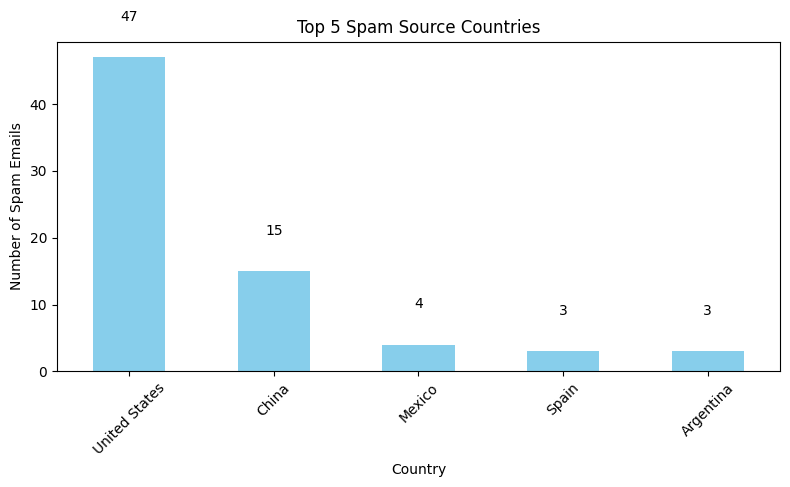

In [30]:
# Top 5 spam source countries (bar chart version with labels)
top_countries = (
    all_emails[all_emails['label'] == 1]["country"]
    .value_counts()
    .head(5)
)

plt.figure(figsize=(8,5))
bars = top_countries.plot(kind='bar', color='skyblue')

# Add text labels above each bar
for i, count in enumerate(top_countries.values):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)

plt.title("Top 5 Spam Source Countries")
plt.xlabel("Country")
plt.ylabel("Number of Spam Emails")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


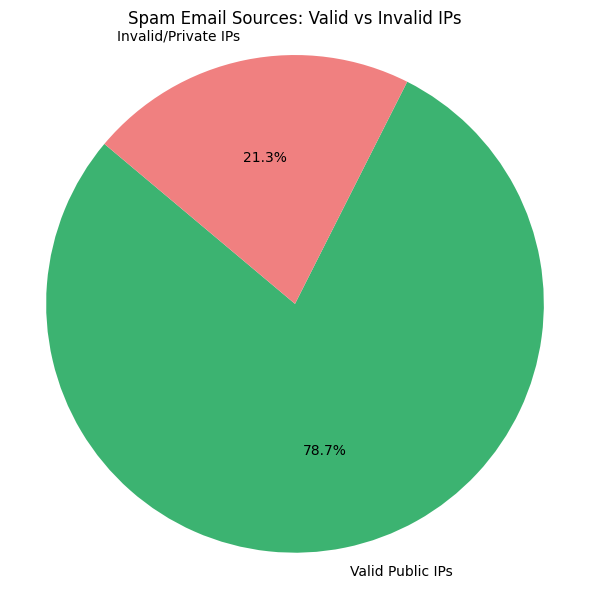

In [31]:
# Count valid and invalid spam IPs
valid_ip_count = all_emails[
    (all_emails['label'] == 1) & 
    (all_emails['ip'].apply(is_valid_ip))
].shape[0]

invalid_ip_count = all_emails[
    (all_emails['label'] == 1) & 
    (~all_emails['ip'].apply(is_valid_ip))
].shape[0]

# Pie chart of valid vs invalid IPs
labels = ['Valid Public IPs', 'Invalid/Private IPs']
sizes = [valid_ip_count, invalid_ip_count]
colors = ['mediumseagreen', 'lightcoral']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title("Spam Email Sources: Valid vs Invalid IPs")
plt.axis('equal')
plt.tight_layout()
plt.show()



📊 Spam Type Distribution:
spam_type
General Spam                 617
Phishing & Account Alerts    408
Commercial Advertisements    295
Business/Investment Scams    114
Antivirus Warnings            80
Name: count, dtype: int64


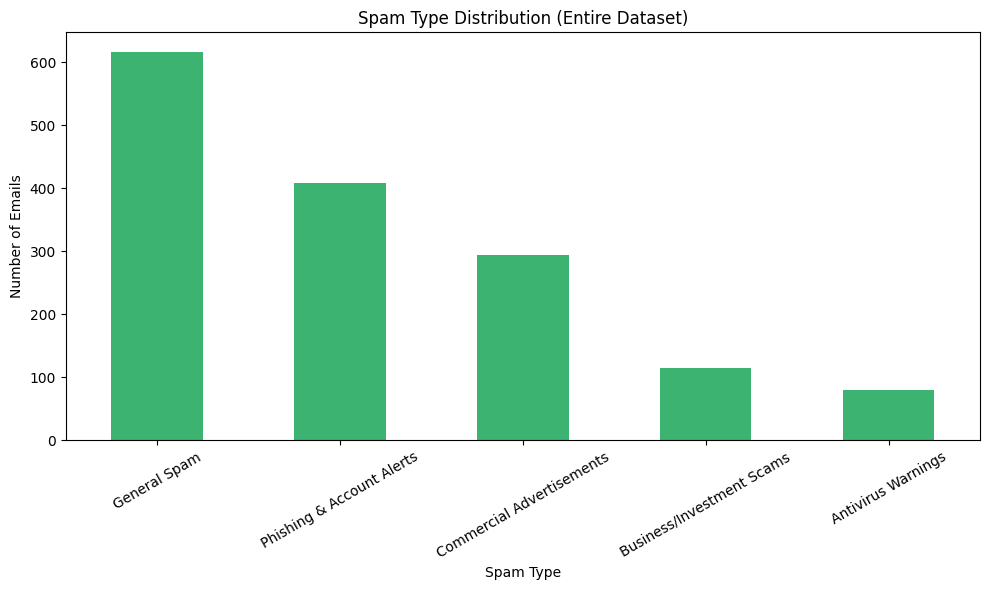

,subject,combined_text
2,Is Neotropin right for you?,Is Neotropin right for you? Unsubscribe: Pleas...
5,Congratulations! Here's Your Diploma!,Congratulations! Here's Your Diploma! Universi...
6,* Promote Your E-Business,* Promote Your E-Business New Page 1 This page...
14,This product appeals to all DVD lovers 9959GLX...,This product appeals to all DVD lovers 9959GLX...
15,Eliminate Debt~No Bankrputcy!,Eliminate Debt~No Bankrputcy! Eliminate your c...
26,"Testing a system, please delete","Testing a system, please delete Please forgive..."
39,Financial Opportunity [6bftc],Financial Opportunity [6bftc] There are more f...
44,一网“惠”天下，一展天下知----2003年4月1日--4,一网“惠”天下，一展天下知----2003年4月1日--4 =?GB2312?B?yNW12...
45,please see see kmuNnWq6p12tdpvINWVAGy,please see see kmuNnWq6p12tdpvINWVAGy
47,Toners and inkjet cartridges for less.... ...,Toners and inkjet cartridges for less.... ...


In [ ]:
def categorize_spam(text):
    text = text.lower()
    if any(keyword in text for keyword in [
        "impersonating", "pretending to be", "fake sender", "spoofed email", 
        "this is not from", "unauthorized email", "suspicious sender"
    ]):
        return "Email Spoofing"
    elif any(keyword in text for keyword in [
    "antivirus", "virus", "ransomware", "malware", "spyware", "trojan", "infected",
    "system scan", "your pc is", "security alert", "protection", "norton", "symantec",
    "systemworks", "protect your computer", "clean your pc", "remove threats"
    ]):
        return "Antivirus Warnings"

    elif any(keyword in text for keyword in [
        "buy now", "sale", "discount", "limited time offer", 
        "promotion", "subscribe now", "exclusive deal", "order today"
    ]):
        return "Commercial Advertisements"
    elif any(keyword in text for keyword in [
        "account suspended", "login now", "verify account", "click here", 
        "update information", "reset password", "unusual activity"
    ]):
        return "Phishing & Account Alerts"
    elif any(keyword in text for keyword in [
    "financial opportunity", "investment", "business proposal", "business relationship",
    "commissions", "publish", "make money", "income opportunity"
    ]):
        return "Business/Investment Scams"
    # else:
    #     return "General Spam"


all_emails["spam_type"] = all_emails.apply(lambda row: categorize_spam(row["text"]) if row["label"] == 1 else None, axis=1)

spam_type_counts = all_emails["spam_type"].value_counts()
print("\n📊 Spam Type Distribution:")
print(spam_type_counts)

plt.figure(figsize=(10,6))
spam_type_counts.plot(kind="bar", color="mediumseagreen")

# Add labels on top of each bar
for i, count in enumerate(spam_type_counts.values):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', fontsize=10)
    
plt.title("Spam Type Distribution (Entire Dataset)")
plt.xlabel("Spam Type")
plt.ylabel("Number of Emails")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

all_emails[all_emails["spam_type"] == "General Spam"][["subject", "combined_text"]].head(20)



In [33]:
# Show spam emails that mention anything about viruses
keywords = ["virus", "trojan", "malware", "spyware", "security alert", "infected", "ransomware", "scan"]
mask = all_emails["text"].str.contains('|'.join(keywords), case=False, na=False)
antivirus_candidates = all_emails[(all_emails['label'] == 1) & mask]

# Preview a few
print(antivirus_candidates[["subject", "text"]].head(10))

                                               subject  \
41                       Relief for all skin disorders   
44                       一网“惠”天下，一展天下知----2003年4月1日--4   
85                                       Press Release   
138                               7000  ���ַ���ؼۣ�����   
192  Re: PROTECT YOUR COMPUTER,YOU NEED SYSTEMWORKS...   
293          Postal Mail Via Email - Anytime, anywhere   
314                                      [SA] 墨水匣批發電子報   
503         Un mois de maintenance informatique OFFERT   
570  Norton Systemworks 2002 Final Clearance       ...   
696  Re: Super CHARGE your desktop or laptop today!...   

                                                  text  
41   Chickweed Healing \nSalve "A Natural Way To He...  
44   =?GB2312?B?yNW12squ0ru97NbQufq5+rzKtefX08nosbi...  
85   The Business Opportunity Alliance Releases the...  
138  Dear cypherpunks , 7000 万（ 绝无重复 ） EMAIL 地址数据库 ...  
192  Norton AD Take\n      Control of Your Computer...  
293  Get Your Posta

In [35]:
# Define antivirus-related keywords
keywords = [
    "antivirus", "virus", "ransomware", "malware", "spyware", "trojan", "infected",
    "system scan", "your pc is", "security alert", "protection", "norton", "symantec"
]

# Filter spam emails that contain any of those keywords in combined_text
mask = (
    (all_emails["label"] == 1) &
    (all_emails["combined_text"].str.contains('|'.join(keywords), case=False, na=False))
)

# Extract matching rows
antivirus_candidates = all_emails[mask]

# Show results
print(antivirus_candidates[["subject", "combined_text"]].head(10))
print(f"\n🔍 Matches found: {len(antivirus_candidates)}")


                                               subject  \
16                     75% REDUCTION IN ROAD ACCIDENTS   
41                       Relief for all skin disorders   
78   Free Adult Videos To: yyyy@netnoteinc.com ID: ...   
85                                       Press Release   
155          urgent and confidential business proposal   
185      HAWAI`I & ENENKIO KINGDOMS  AMERICANS SHAME !   
187                               Insurance Quote Site   
192  Re: PROTECT YOUR COMPUTER,YOU NEED SYSTEMWORKS...   
296    Look 10 Years Younger-FREE SAMPLE !!!!!!!! esoy   
325                                     Need a Lawyer?   

                                         combined_text  
16   75% REDUCTION IN ROAD ACCIDENTS 75% Reduction ...  
41   Relief for all skin disorders Chickweed Healin...  
78   Free Adult Videos To: yyyy@netnoteinc.com ID: ...  
85   Press Release The Business Opportunity Allianc...  
155  urgent and confidential business proposal Your...  
185  HAWAI`I & ENEN